In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("../../dataset/raw/train.csv")

<Axes: xlabel='technical_solution_proposed', ylabel='damage_grade'>

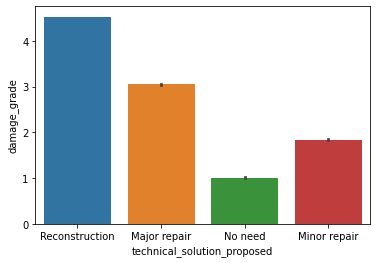

In [3]:
# viz damage grade vs technical solution proposed

sns.barplot(x='technical_solution_proposed', y='damage_grade', data=train)

In [4]:
train[train["damage_grade"] == 5]["technical_solution_proposed"].value_counts()

Reconstruction    16959
Major repair          3
Minor repair          3
Name: technical_solution_proposed, dtype: int64

<Axes: >

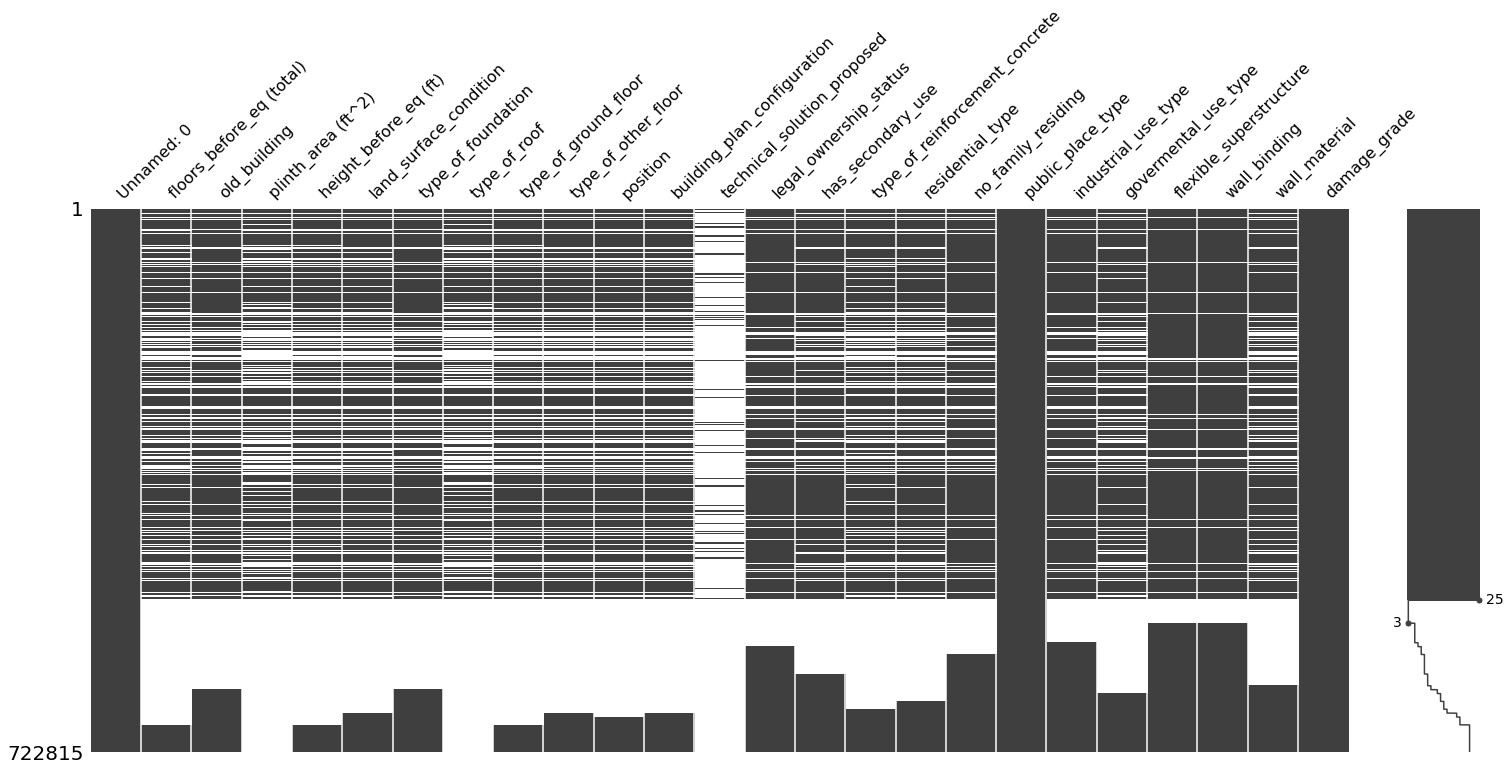

In [5]:
import missingno as msno

msno.matrix(train)

In [6]:
from tqdm import tqdm
train_cp = train.copy()
print(train_cp["technical_solution_proposed"].isnull().sum())

for idx, row in tqdm(train_cp.iterrows(), total=train_cp.shape[0]):
    if pd.isnull(row["technical_solution_proposed"]):
        if row["damage_grade"] == 5:
            train_cp.at[idx, "technical_solution_proposed"] = "Reconstruction"
        else:
            train_cp.at[idx, "technical_solution_proposed"] = np.nan

print(train_cp["technical_solution_proposed"].isnull().sum())


676014


100%|██████████| 722815/722815 [00:38<00:00, 18948.04it/s]

431348


<Axes: >

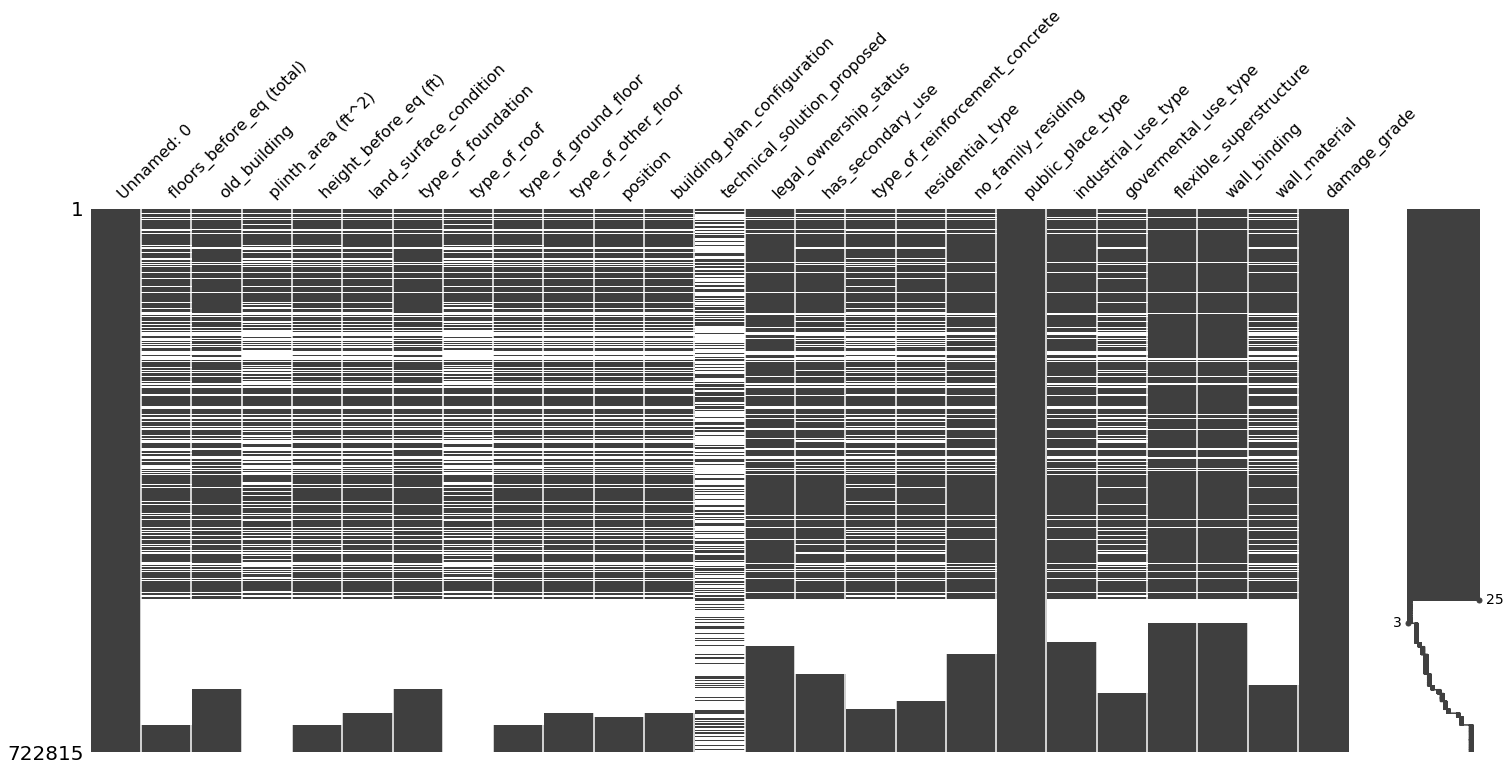

In [7]:
msno.matrix(train_cp)

In [8]:
train["technical_solution_proposed"].value_counts()

Reconstruction    28847
Major repair       7963
Minor repair       6852
No need            3139
Name: technical_solution_proposed, dtype: int64

In [9]:
train_cp["technical_solution_proposed"].value_counts()

Reconstruction    273513
Major repair        7963
Minor repair        6852
No need             3139
Name: technical_solution_proposed, dtype: int64

In [10]:
train_cp.drop(["Unnamed: 0", "no_family_residing"], axis=1, inplace=True)

In [11]:
train_cp.dropna(inplace=True)
train_cp.shape

(139023, 23)

In [12]:
train_cp.to_csv("../../dataset/processed/train_cleaned_v4_139k.csv", index=False)

In [13]:
from category_encoders.target_encoder import TargetEncoder


def clean(df, mode="test"):
    ordinal_col = ["land_surface_condition", "technical_solution_proposed"]

    binary_col = ["flexible_superstructure", "public_place_type",
                "govermental_use_type", "has_secondary_use"]
    numerical_col = ["floors_before_eq (total)", "old_building",
                    "plinth_area (ft^2)", "height_before_eq (ft)"]
    target_col = ["damage_grade"]
    categorical_col_lt5 = [col for col in train_cp.columns if col not in ordinal_col +
                        binary_col + numerical_col + target_col and train_cp[col].nunique() <= 4]
    cat_col = [col for col in train_cp.columns if col not in ordinal_col +
            binary_col + numerical_col + target_col and train_cp[col].nunique() >= 5]
    angka = {
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "five": 5,
        "six": 6,
        "seven": 7,
        "eight": 8,
        "nine": 9,
        "1st": 1,
        "2nd": 2,
        "3rd": 3,
        "fifth": 5,
        "second": 2,
        "third": 3,
        "3.00": 3,
    }

    delete = {
        "story": "",
        "stories": "",
        "floor": "",
        "floors": "",
        "has": "",
        "there is": "",
        "just": "",
        "-": "",
        "fl": "",
        "/": "",
    }

    df["floors_before_eq (total)"] = df["floors_before_eq (total)"]\
        .str.lower()\
        .replace(delete, regex=True)\
        .str.strip()\
        .replace(angka, regex=True)

    df["floors_before_eq (total)"] = df["floors_before_eq (total)"].astype(
        "float")
    df["plinth_area (ft^2)"] = df["plinth_area (ft^2)"].str.lower()

    df["plinth_area (ft^2)"] = df["plinth_area (ft^2)"].apply(
        lambda x: x.replace(" ft^2", ""))
    df["plinth_area (ft^2)"] = df["plinth_area (ft^2)"].apply(
        lambda x: x.replace("more than ", ""))
    df["plinth_area (ft^2)"] = df["plinth_area (ft^2)"].astype(
        "float")

    type_of_foundation_dict = {
        # "Mud mortar-Stone/Brick": "Clay mortar-Stone/Brick",
        "Bamboo/TImber": "Bamboo or Timber",
        "Bamboo/Timber": "Bamboo or Timber",
        "RC": "Reinforced Concrete",
        "Others": "Other",
        "Cement-Stone or Cement-Brick": "Cement-Stone/Brick"
    }

    df["type_of_foundation"] = df["type_of_foundation"]\
        .replace(type_of_foundation_dict)\
        .str.strip()

    type_of_roof_dict = {
        "Bamboo/TImber-Heavy Roof": "Bamboo/Timber Heavy roof",
        "Bamboo/TImber-Light Roof": "Bamboo or Timber Light roof",
        "Bamboo/Timber Light roof": "Bamboo or Timber Light roof ",
        "reinforced cement concrete/rb/rbc": "rcc/rb/rbc",
        "Reinforced brick concrete/rcc/rbc": "rcc/rb/rbc",
        "Bamboo or Timber Heavy roof": "Bamboo/Timber Heavy roof",
        "Reinforced Brick Slab/rcc/rbc": "rcc/rb/rbc",
    }

    df["type_of_roof"] = df["type_of_roof"].replace(
        type_of_roof_dict).str.strip()

    type_of_ground_floor_dict = {
        "rc": "reinforced concrete",
        "brick/stone": "brick or stone",
        # "lumber": "wood",
        # "timber": "wood",
        # "mud": "clay"
    }

    df["type_of_ground_floor"] = df["type_of_ground_floor"].str.lower()\
        .replace(type_of_ground_floor_dict)\


    type_of_other_floor_dict = {
        # "lumber-plank": "wood-plank",
        # "timber-planck": "wood-plank",
        "timber/bamboo-mud": "wood-mud or bamboo mud",
        "reinforced cement concrete/rb/rbc": "rcc/rb/rbc",
        "wood or bamboo mud": "wood-mud or bamboo mud",
        "timber mud or bamboo-mud": "wood-mud or bamboo mud"
    }

    df["type_of_other_floor"] = df["type_of_other_floor"]\
        .str.lower()\
        .replace(type_of_other_floor_dict)

    # df['no_family_residing'] = df['no_family_residing'].replace(
    #     'None', '0.0').astype('float')

    df["residential_type"] = df["residential_type"].replace({
        "Other Residential Type": "Other"
    })
    df['govermental_use_type'] = df['govermental_use_type'].replace(
        ['Police Offices'], 'Govermental Buildings')
    df["public_place_type"] = df["public_place_type"]\
        .apply(lambda x: "Public" if x != "Non-public" else "Non-public")

    legal_ownership_status_dict = {
        "Private": "Private",
        "Private Use": "Private",
        "Prvt": "Private",
        "Privste": "Private",
        "Public Use": "Public",
        "Public Space": "Public",
        "Institutional Use": "Institutional",
        "Institutionals": "Institutional",
        "Unknown": "Other",
        "Unspecified": "Other",
    }

    df["legal_ownership_status"] = df["legal_ownership_status"].str.strip(
    ).replace(legal_ownership_status_dict)

    land_surface_condition_dict = {
        "Steep slope": 0,
        "Moderate slope": 1,
        "Flat": 2,
    }

    df["land_surface_condition"] = df["land_surface_condition"].replace(
        land_surface_condition_dict)

    technical_solution_proposed_dict = {
        "Reconstruction": 0,
        "Major repair": 1,
        "Minor repair": 2,
        "No need": 3,
    }

    df["technical_solution_proposed"] = df["technical_solution_proposed"].replace(
        technical_solution_proposed_dict)

    flexible_superstructure_dict = {
        "unavailable": 0,
        "available": 1,
    }

    df["flexible_superstructure"] = df["flexible_superstructure"].replace(
        flexible_superstructure_dict)

    public_place_type_dict = {
        "Public": 0,
        "Non-public": 1,
    }

    df["public_place_type"] = df["public_place_type"].replace(
        public_place_type_dict)

    governmental_use_type_dict = {
        "Govermental Buildings": 0,
        "Non-govermental": 1,
    }

    df["govermental_use_type"] = df["govermental_use_type"].replace(
        governmental_use_type_dict)

    # ohe_df = pd.DataFrame(ohe.transform(train_cp[categorical_col_lt5]))
    # ohe_df.columns = ohe.get_feature_names(categorical_col_lt5)

    # train_ohe = train_cp.copy()
    # for cat in categorical_col_lt5:
    #     train_ohe.drop(cat, axis=1, inplace=True)

    # print(train_ohe.shape)

    # train_ohe_merge = pd.concat([train_ohe, ohe_df], axis=1)

    # print(train_ohe_merge.shape)
    train_ohe_merge = df.copy()
    # train_ohe_merge[numerical_col] = s.transform(
    #     train_ohe_merge[numerical_col])

    enc_df = train_ohe_merge.copy()
    if mode == "test":
        enc_df[cat_col + categorical_col_lt5] = enc.transform(
            train_ohe_merge[cat_col + categorical_col_lt5])
    else:
        enc = TargetEncoder(cols=cat_col + categorical_col_lt5)
        enc.fit(train_ohe_merge[cat_col + categorical_col_lt5],
                train_ohe_merge["damage_grade"])
        enc_df[cat_col + categorical_col_lt5] = enc.transform(
            train_ohe_merge[cat_col + categorical_col_lt5])

    return enc_df


In [14]:
train_enc = train_cp.copy()
train_enc = clean(train_enc, "train")
train_enc.head()

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,has_secondary_use,type_of_reinforcement_concrete,residential_type,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
1,3.0,3.0,985.0,18.0,2,4.670803,4.618140,4.632378,4.645948,4.536437,...,0.0,4.587568,4.567367,1,4.543022,1,0,4.686118,4.689119,5.0
9,1.0,33.0,600.0,9.0,2,4.669017,4.590882,4.634329,4.218829,4.536437,...,0.0,4.587568,4.567367,1,4.543022,1,0,4.686118,4.689119,5.0
21,1.0,22.0,300.0,10.0,1,4.670803,4.590882,4.634329,4.218829,4.536437,...,0.0,4.587568,4.567367,1,4.543022,1,0,4.686118,4.689119,5.0
24,2.0,12.0,358.0,12.0,2,4.669017,4.618140,4.632378,4.645948,4.536437,...,0.0,4.587568,4.567367,1,4.543022,1,0,4.686118,4.689119,5.0
26,2.0,45.0,250.0,20.0,2,4.669017,4.590882,4.634329,4.645948,4.536437,...,0.0,4.587568,4.567367,1,4.543022,1,0,4.686118,4.689119,5.0


In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X = train_enc.drop(["damage_grade"], axis=1)
y = train_enc["damage_grade"].copy()
y -= 1


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69420, stratify=y)

print(f"""\
X_train: {X_train.shape}
X_test: {X_test.shape}""")

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(f1_score(y_test, y_pred, average="macro"))

X_train: (104267, 22)
X_test: (34756, 22)
0.6488127417707641


In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average="macro"))

0.6448921141547583


In [18]:
rf_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)


In [24]:
selected_features_rf = rf_imp[:19]["feature"].values

X_train_imp = X_train[selected_features_rf]
X_test_imp = X_test[selected_features_rf]

rf.fit(X_train_imp, y_train)

y_pred = rf.predict(X_test_imp)

print(f1_score(y_test, y_pred, average="macro"))    

0.6502023684409581


In [25]:
xgb_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb.feature_importances_
}).sort_values("importance", ascending=False)

In [30]:
f1 = {}
for i in tqdm(range(1, len(X_train.columns) + 1), total=len(X_train.columns)):
    selected_features_xgb = xgb_imp[:i]["feature"].values

    X_train_imp = X_train[selected_features_xgb]
    X_test_imp = X_test[selected_features_xgb]
    xgb = XGBClassifier(random_state=42)

    xgb.fit(X_train_imp, y_train)

    y_pred = xgb.predict(X_test_imp)

    f1[i] = f1_score(y_test, y_pred, average="macro")

f1

100%|██████████| 22/22 [01:43<00:00,  4.68s/it]


{1: 0.6479513627010467,
 2: 0.6479513627010467,
 3: 0.6479513627010467,
 4: 0.6464224371384419,
 5: 0.6471048661412864,
 6: 0.6465855963719672,
 7: 0.6468911856824532,
 8: 0.6473758329152608,
 9: 0.6461368968422627,
 10: 0.6491840474347845,
 11: 0.648200526969412,
 12: 0.6483961089484462,
 13: 0.6488026061859195,
 14: 0.6491458268201551,
 15: 0.6493802156948637,
 16: 0.6506837746234095,
 17: 0.647281432335278,
 18: 0.6494153110679293,
 19: 0.6482917540777184,
 20: 0.6459157115155668,
 21: 0.6458923186458195,
 22: 0.6465572560102087}

In [31]:
selected_features_xgb = xgb_imp[:16]["feature"].values

X_train_imp = X_train[selected_features_xgb]
X_test_imp = X_test[selected_features_xgb]

In [32]:
import optuna 


def objective(trial):

    params = {
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
    }

    model = XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred, average='macro')


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=10, timeout=600)

[I 2023-04-12 09:59:09,947] A new study created in memory with name: no-name-834ca4e7-2ee0-4151-ab40-6101e599fc83
